# 2D Vis (Clean)

In [1]:
import json
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import binned_statistic_2d
from datasets import load_dataset, load_from_disk
from tqdm.auto import tqdm
%config InlineBackend.figure_format = 'svg'

import sys
sys.path.insert(0, "../src/")
sys.path.insert(0, "..")
from config import REPO_ROOT
from utils import postprocessing


INFO 07-15 16:09:39 [__init__.py:239] Automatically detected platform cuda.


## Discrete

In [2]:
def plot_decision_boundary_discrete(
    dataset_name: str,
    variables: list[str],
    *,
    filepath: str | Path, # FED0C3, FECEC0
    colours: tuple[str, str] = ("#FAD2C4", "#C9DBF7"), # fdae61, abd9e9 -->  # F3B65C, 5890E8 --> E3ACB2, BBCAE0   ["#FFECE7", "#E0EAFB"] #FED9CE", "#C0D6F6 # [RED, BLUE]
    save_path: str | Path | None = None,
    verbose: int = 0,
    points_to_mark_1: int | list[int] = 0,
    points_to_mark_2: int | list[int] = 0,
    offset: float = 0.0,
    cf_density: bool = False,
    legend_setting: bool = False,
    plot_specific_points: list[int] | None = None,
    original_point_colour: str = '#FF2020',            # POINT COLOURS (RED) 0D47A1. FC6539
    cf_point_colour: str = '#0058DC',
    legend_labels: tuple[str, str, str, str] = ("Above $50,000", "Below $50,000", "Original inputs", "SCEs"),
    density_legend_labels: tuple[str, str] = ("SCEs targeting Above $50,000", "SCEs targeting Below $50,000"),
):
    """Plot a discrete decision boundary heatmap."""
    filepath = Path(filepath)
    model_name = filepath.stem

    results = postprocessing(filepath, force=True,
                             distance_metric="gower", save=True,
                             explicit_dataset="")
    results = {int(k): v for k, v in results.items()}

    with open(REPO_ROOT / 'src/models_datasets/datasets.json') as f:
        ds_info = json.load(f)[dataset_name]
    if ds_info.get('local', False):
        dataset = load_from_disk(REPO_ROOT / ds_info['filepath'])
    else:
        dataset = load_dataset(ds_info['filepath'], name=ds_info['name'], split=ds_info['split'])
    id_to_index = {id_: idx for idx, id_ in enumerate(dataset['id'])}
    option_to_code = {opt: i for i, opt in enumerate(ds_info['options'])}

    var0, var1, decisions = [], [], []
    for v in results.values():
        idx = id_to_index.get(v.get('dataset_id'))
        if idx is not None:
            v[variables[0]] = dataset[idx][variables[0]]
            v[variables[1]] = dataset[idx][variables[1]]
        else:
            v[variables[0]] = np.nan
            v[variables[1]] = np.nan
        decisions.append(option_to_code.get(v.get('original_answer'), np.nan))
        var0.append(v[variables[0]])
        var1.append(v[variables[1]])

    var0 = np.asarray(var0)
    var1 = np.asarray(var1)
    decisions = np.asarray(decisions)

    def unique_value(x):
        ux = np.unique(x)
        return ux[0] if len(ux) == 1 else np.nan

    bins0 = np.arange(np.nanmin(var0), np.nanmax(var0) + 2, 1)
    bins1 = np.arange(np.nanmin(var1), np.nanmax(var1) + 2, 1)
    stat, _, _, _ = binned_statistic_2d(var0, var1, decisions,
                                        statistic=unique_value,
                                        bins=[bins0, bins1])

    categories = np.sort(np.unique(decisions[~np.isnan(decisions)]))
    N = len(categories)
    cat_to_index = {cat: i for i, cat in enumerate(categories)}
    def map_category(val):
        return cat_to_index.get(float(val), -1) if not np.isnan(val) else -1
    stat_indices = np.vectorize(map_category)(stat)
    stat_indices = np.ma.masked_where(stat_indices == -1, stat_indices)

    colours_with_alpha = [mcolors.to_rgba(c, alpha=1) for c in colours]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colours_with_alpha, N)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, N+0.5), ncolors=N)

    plt.figure(figsize=(8, 8))
    im = plt.imshow(stat_indices.T, origin='lower', aspect='auto',
                    extent=[bins0[0], bins0[-1], bins1[0], bins1[-1]],
                    cmap=cmap, norm=norm, alpha=1)

    # Add decision boundary lines along the edges of squares
    if N >= 2:  # Need at least 2 classes for boundaries
        # Create a copy without masked values for boundary detection
        stat_for_boundary = stat_indices.filled(-1)
        
        # Lists to store line coordinates
        boundary_lines_x = []
        boundary_lines_y = []
        
        # Iterate through grid and find boundaries
        for i in range(stat_for_boundary.shape[0]):
            for j in range(stat_for_boundary.shape[1]):
                current = stat_for_boundary[i, j]
                if current == -1:  # Skip masked values
                    continue
                
                # Check right neighbor (vertical boundary)
                if i + 1 < stat_for_boundary.shape[0]:
                    right = stat_for_boundary[i + 1, j]
                    if right != -1 and current != right:
                        # Draw vertical line at right edge of current cell
                        x_line = bins0[i + 1]
                        y_start = bins1[j]
                        y_end = bins1[j + 1]
                        boundary_lines_x.extend([x_line, x_line, None])
                        boundary_lines_y.extend([y_start, y_end, None])
                
                # Check top neighbor (horizontal boundary)
                if j + 1 < stat_for_boundary.shape[1]:
                    top = stat_for_boundary[i, j + 1]
                    if top != -1 and current != top:
                        # Draw horizontal line at top edge of current cell
                        y_line = bins1[j + 1]
                        x_start = bins0[i]
                        x_end = bins0[i + 1]
                        boundary_lines_x.extend([x_start, x_end, None])
                        boundary_lines_y.extend([y_line, y_line, None])
        
        # Plot the boundary lines
        if boundary_lines_x:  # Only plot if we have boundaries
            plt.plot(boundary_lines_x, boundary_lines_y, 'k-', linewidth=0.7, alpha=0.8) ###### EDIT WIDTH

    legend_handles = []
    # Reorder categories to show Decision 1 first, then Decision 0
    sorted_categories = sorted(categories, reverse=True)
    for cat in sorted_categories:
        idx = cat_to_index[cat]
        # Use custom legend labels based on category
        if cat == 1:
            label = legend_labels[0]  # "Above $50,000"
        elif cat == 0:
            label = legend_labels[1]  # "Below $50,000"
        else:
            label = f'Decision {cat}'
        patch = Patch(facecolor=cmap(idx/(N-1 if N>1 else 1)), label=label, edgecolor='grey', linewidth=0.5) 
        legend_handles.append(patch)

    # Plot specific original points and counterfactuals
    if plot_specific_points:
        original_x, original_y = [], []
        cf_x, cf_y = [], []
        
        for idx in plot_specific_points:
            if idx in results:
                try:
                    # Original point coordinates
                    orig_x = results[idx][variables[0]]
                    orig_y = results[idx][variables[1]]
                    original_x.append(orig_x)
                    original_y.append(orig_y)
                    
                    # Counterfactual coordinates
                    cf_var_x = variables[0] + '_CF'
                    cf_var_y = variables[1] + '_CF'
                    cf_point_x = results[idx][cf_var_x]
                    cf_point_y = results[idx][cf_var_y]
                    cf_x.append(cf_point_x)
                    cf_y.append(cf_point_y)
                    print(orig_x, orig_y, cf_point_x, cf_point_y)
                except KeyError as e:
                    if verbose > 0:
                        print(f"Warning: Missing data for index {idx}: {e}")
                    continue
        
        # Plot original points as crosses
        if original_x:
            print(original_x)
            plt.scatter(original_x, original_y, c=original_point_colour, marker='x', 
                       s=95, linewidths=2, label='Original Points', zorder=10)
        
        # Plot counterfactual points as crosses  
        if cf_x:
            print(cf_x)
            plt.scatter(cf_x, cf_y, c=cf_point_colour, marker='x', 
                       s=95, linewidths=2, label='Counterfactuals', zorder=10)
        
        # Add to legend with custom labels
        if original_x:
            legend_handles.append(Line2D([], [], marker='x', linestyle='None',
                                       markerfacecolor=original_point_colour, 
                                       markeredgecolor=original_point_colour,
                                       markersize=10, markeredgewidth=2,
                                       label=legend_labels[2]))  # "Original inputs"
        if cf_x:
            legend_handles.append(Line2D([], [], marker='x', linestyle='None',
                                       markerfacecolor=cf_point_colour, 
                                       markeredgecolor=cf_point_colour,
                                       markersize=10, markeredgewidth=2,
                                       label=legend_labels[3]))  # "SCEs"

    groups = [
        (points_to_mark_1, '#0D47A1', density_legend_labels[0]), # Blue for targeting Above $50,000
        (points_to_mark_2, '#E65100', density_legend_labels[1])  # Orange for targeting Below $50,000
    ]
    for pts, colour, label in groups:
        if not pts:
            continue
        samples = random.sample(list(results.keys()), pts) if isinstance(pts, int) else pts
        classes = ds_info['options']
        cf_coords = {c: {'x': [], 'y': []} for c in classes}
        for i in samples:
            try:
                vars_cf = [x + '_CF' for x in variables]
                vcf = [results[i][var] for var in vars_cf]
                target = results[i]['selected_complement']
                cf_coords[target]['x'].append(vcf[0] + offset)
                cf_coords[target]['y'].append(vcf[1] + offset)
            except Exception:
                continue
        for coords in cf_coords.values():
            plt.scatter(coords['x'], coords['y'], c=colour, alpha=0.15, s=80, edgecolors='none')
        legend_handles.append(Line2D([], [], marker='o', linestyle='None',
                                     markerfacecolor=colour, markeredgecolor=colour,
                                     alpha=0.4, markersize=10, label=label))

    if legend_setting:
        ax = plt.gca()
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.legend(handles=legend_handles, loc='lower right', frameon=True, fontsize=16, ncol=1)
        ax.get_legend().get_frame().set_edgecolor('grey')

    ax = plt.gca()
    ax.tick_params(axis='x', labelbottom=False)  # or labeltop=False
    ax.tick_params(axis='y', labelleft=False)    # or labelright=False

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', transparent=False, dpi=600)
    plt.show()
    return results

Extracted Dataset Name: income_minimal


  0%|          | 0/1920 [00:00<?, ?it/s]

29 13 29.0 21.0
44 3 44.0 21.0
92 17 92.0 21.0
[29, 44, 92]
[29.0, 44.0, 92.0]


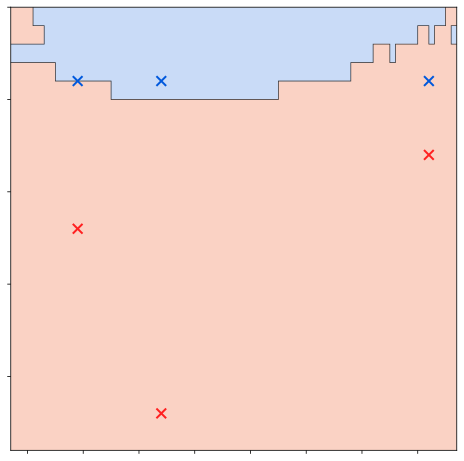

In [5]:
started_below = []
started_above = []
results = plot_decision_boundary_discrete(
    'income',
    ['AGEP', 'SCHL'],
    filepath = '../results/income_minimal/claude_3_7_sonnet.json', # /analysis/temperature_1 #'../results/income_minimal/DeepSeek_70B.json'
    verbose=0,
    points_to_mark_1=started_below,
    points_to_mark_2=started_above,
    offset=0.5,
    plot_specific_points = [300, 650, 1816], #[300, 650, 1816], #[1234, 704, 426, 300, 650, 1816],#[300, 650, 1816],  # 990, 1816
    cf_density=True,
    save_path = REPO_ROOT / 'figures/DeepSeek_32B.png',
    legend_setting=False
)



Processing model: llama3_3_70B
Extracted Dataset Name: income


  0%|          | 0/1920 [00:00<?, ?it/s]

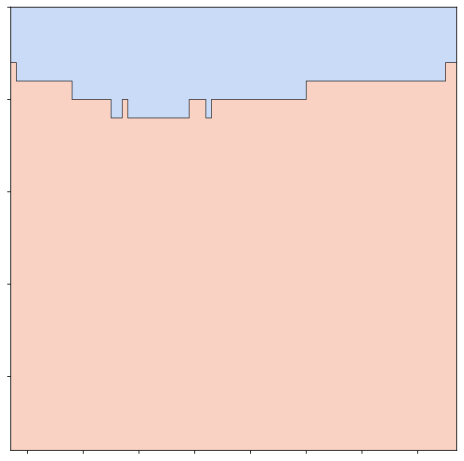

Extracted Dataset Name: income


  0%|          | 0/1920 [00:00<?, ?it/s]

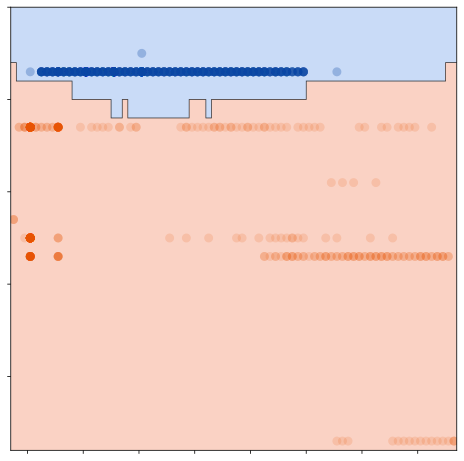

Extracted Dataset Name: income_minimal


  0%|          | 0/1920 [00:00<?, ?it/s]

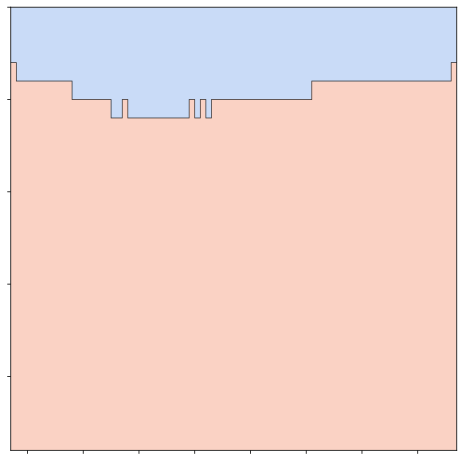

Extracted Dataset Name: income_minimal


  0%|          | 0/1920 [00:00<?, ?it/s]

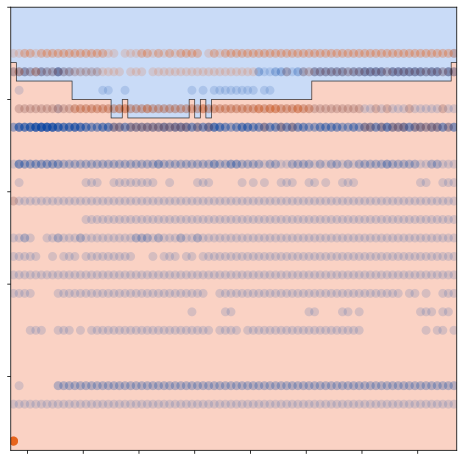

Processing model: o3
Extracted Dataset Name: income


  0%|          | 0/1920 [00:00<?, ?it/s]

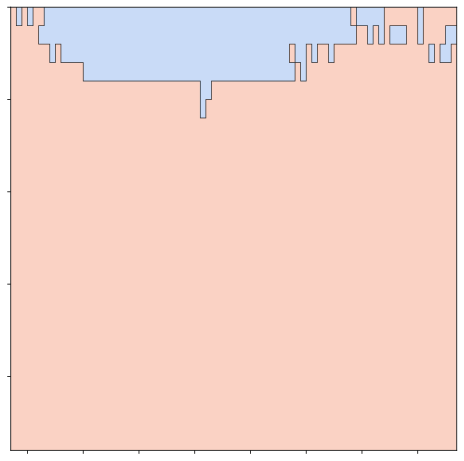

Extracted Dataset Name: income


  0%|          | 0/1920 [00:00<?, ?it/s]

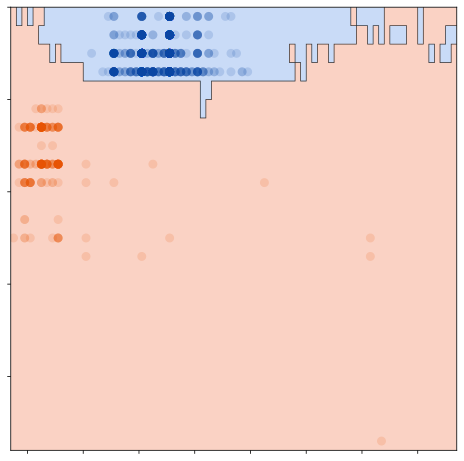

Extracted Dataset Name: income_minimal


  0%|          | 0/1920 [00:00<?, ?it/s]

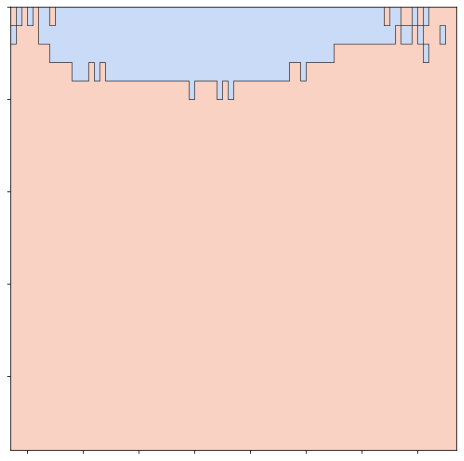

Extracted Dataset Name: income_minimal


  0%|          | 0/1920 [00:00<?, ?it/s]

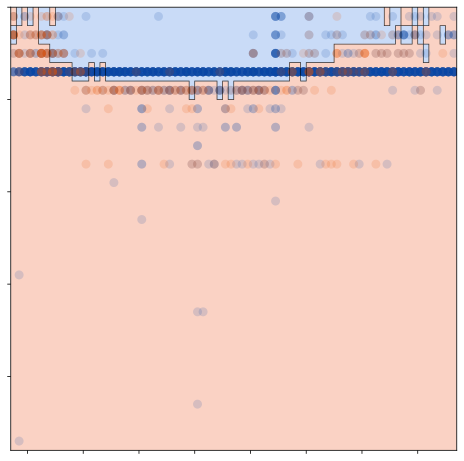

In [4]:
# Generate density plots for both o3 and llama3_3_70B models
models = ["llama3_3_70B", "o3"]

for model in models:
    print(f"Processing model: {model}")
    
    # First plot without density grouping
    results = plot_decision_boundary_discrete(
        'income',
        ['AGEP', 'SCHL'],
        filepath = f'../results/income/{model}.json',
        verbose=0,
        points_to_mark_1=[],
        points_to_mark_2=[],
        offset=0.5,
        plot_specific_points = [],
        cf_density=True,
        save_path = REPO_ROOT / f'figures/{model}.png',
        legend_setting=False
    )
    
    # Get started_below and started_above groups
    started_below = []
    started_above = []
    for k,v in results.items():
        if v['original_answer']=='Below $50,000':
            started_below.append(k)
        else:
            started_above.append(k)
    
    # Second plot with density grouping for normal setting
    results = plot_decision_boundary_discrete(
        'income',
        ['AGEP', 'SCHL'],
        filepath = f'../results/income/{model}.json',
        verbose=0,
        points_to_mark_1=started_below,
        points_to_mark_2=started_above,
        offset=0.5,
        plot_specific_points = [],
        cf_density=True,
        save_path = REPO_ROOT / f'figures/{model}.png',
        legend_setting=False
    )
    
    # Load minimal dataset results
    results = plot_decision_boundary_discrete(
        'income',
        ['AGEP', 'SCHL'],
        filepath = f'../results/income_minimal/{model}.json',
        verbose=0,
        points_to_mark_1=[],
        points_to_mark_2=[],
        offset=0.5,
        plot_specific_points = [],
        cf_density=True,
        save_path = REPO_ROOT / f'figures/{model}_minimal.png',
        legend_setting=False
    )
    
    # Get groups for minimal setting
    started_below = []
    started_above = []
    for k,v in results.items():
        if v['original_answer']=='Below $50,000':
            started_below.append(k)
        else:
            started_above.append(k)
    
    # Final plot with density grouping and legend for minimal setting
    results = plot_decision_boundary_discrete(
        'income',
        ['AGEP', 'SCHL'],
        filepath = f'../results/income_minimal/{model}.json',
        verbose=0,
        points_to_mark_1=started_below,
        points_to_mark_2=started_above,
        offset=0.5,
        plot_specific_points = [],
        cf_density=True,
        save_path = REPO_ROOT / f'figures/{model}_minimal.png',
        legend_setting=False
    )

In [49]:
results
started_below = []
started_above = []
for k,v in results.items():
    if v['original_answer']=='Below $50,000':
        started_below.append(k)
    else:
        started_above.append(k)

In [50]:
# random three points
import random
points = []
for i in [0,1,2]:
    points.append(random.randint(0, 1919))

points

[477, 465, 302]

# Discrete decision boundaries for high-dimensional settings

In [51]:
def plot_decision_boundary_discrete_high_dims(
    dataset_name: str,
    variables: list[str],
    *,
    filepath: str | Path,
    fixed_vars: dict[str, float | int | str] | None = None,
    colours: tuple[str, str] = ("#fdae61", "#abd9e9"),
    save_path: str | Path | None = None,
    verbose: int = 0,
    points_to_mark_1: int | list[int] = 0,
    points_to_mark_2: int | list[int] = 0,
    offset: float = 0.0,
    cf_density: bool = False,
    legend_setting: bool = False,
):
    """Plot a discrete decision boundary heatmap for high dimensional datasets."""
    filepath = Path(filepath)
    model_name = filepath.stem
    fixed_vars = fixed_vars or {}

    results = postprocessing(filepath, force=True,
                             distance_metric="gower", save=True,
                             explicit_dataset="")
    results = {int(k): v for k, v in results.items()}

    with open(REPO_ROOT / 'src/models_datasets/datasets.json') as f:
        ds_info = json.load(f)[dataset_name]
    if ds_info.get('local', False):
        dataset = load_from_disk(REPO_ROOT / ds_info['filepath'])
    else:
        dataset = load_dataset(ds_info['filepath'], name=ds_info['name'], split=ds_info['split'])
    id_to_index = {id_: idx for idx, id_ in enumerate(dataset['id'])}
    option_to_code = {opt: i for i, opt in enumerate(ds_info['options'])}

    exclude_columns = {"id", "description", "choices", "instruction", "question",
                       "choice_question_prompt", "numeric_question", "label",
                       "numeric_question_prompt"}
    feature_cols = [c for c in dataset.column_names if c not in exclude_columns]
    if len(feature_cols) - len(fixed_vars) != 2:
        raise ValueError('Number of remaining variables after fixing variables must be 2.')

    var0, var1, decisions = [], [], []
    for v in results.values():
        idx = id_to_index.get(v.get('dataset_id'))
        if idx is None:
            continue
        row = dataset[idx]
        if any(row.get(k) != val for k, val in fixed_vars.items()):
            continue
        v[variables[0]] = row[variables[0]]
        v[variables[1]] = row[variables[1]]
        decisions.append(option_to_code.get(v.get('original_answer'), np.nan))
        var0.append(v[variables[0]])
        var1.append(v[variables[1]])

    var0 = np.asarray(var0)
    var1 = np.asarray(var1)
    decisions = np.asarray(decisions)
    if len(var0) == 0 or len(var1) == 0:
        raise ValueError('No points remaining after filtering with fixed_vars.')

    def unique_value(x):
        ux = np.unique(x)
        return ux[0] if len(ux) == 1 else np.nan

    uniq0 = np.sort(np.unique(var0[~np.isnan(var0)]))
    uniq1 = np.sort(np.unique(var1[~np.isnan(var1)]))
    step0 = np.min(np.diff(uniq0)) if len(uniq0) > 1 else 1
    step1 = np.min(np.diff(uniq1)) if len(uniq1) > 1 else 1
    bins0 = np.concatenate((uniq0 - step0/2, [uniq0[-1] + step0/2]))
    bins1 = np.concatenate((uniq1 - step1/2, [uniq1[-1] + step1/2]))

    stat, _, _, _ = binned_statistic_2d(var0, var1, decisions,
                                        statistic=unique_value,
                                        bins=[bins0, bins1])

    categories = np.sort(np.unique(decisions[~np.isnan(decisions)]))
    N = len(categories)
    if N < 2:
        raise ValueError('Need at least two decision categories to plot heatmap.')
    cat_to_index = {cat: i for i, cat in enumerate(categories)}
    def map_category(val):
        return cat_to_index.get(float(val), -1) if not np.isnan(val) else -1
    stat_indices = np.vectorize(map_category)(stat)
    stat_indices = np.ma.masked_where(stat_indices == -1, stat_indices)

    colours_with_alpha = [mcolors.to_rgba(c, alpha=0.7) for c in colours]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colours_with_alpha, N)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, N+0.5), ncolors=N)

    plt.figure(figsize=(8, 8))
    plt.imshow(stat_indices.T, origin='lower', aspect='auto',
               extent=[bins0[0], bins0[-1], bins1[0], bins1[-1]],
               cmap=cmap, norm=norm, alpha=0.95)

    legend_handles = []
    for cat in categories:
        idx = cat_to_index[cat]
        patch = Patch(color=cmap(idx/(N-1 if N>1 else 1)), label=f'Decision {cat}')
        legend_handles.append(patch)

    groups = [
        (points_to_mark_1, '#0D47A1', 'Group 1'),
        (points_to_mark_2, '#E65100', 'Group 2')
    ]
    for pts, colour, label in groups:
        if not pts:
            continue
        samples = random.sample(list(results.keys()), pts) if isinstance(pts, int) else pts
        classes = ds_info['options']
        cf_coords = {c: {'x': [], 'y': []} for c in classes}
        for i in samples:
            try:
                vars_cf = [x + '_CF' for x in variables]
                vcf = [results[int(i)][var] for var in vars_cf]
                target = results[int(i)]['selected_complement']
                cf_coords[target]['x'].append(vcf[0] + offset)
                cf_coords[target]['y'].append(vcf[1] + offset)
            except Exception:
                continue
        for coords in cf_coords.values():
            plt.scatter(coords['x'], coords['y'], c=colour, alpha=0.15, s=80, edgecolors='none')
        legend_handles.append(Line2D([], [], marker='o', linestyle='None',
                                     markerfacecolor=colour, markeredgecolor=colour,
                                     alpha=0.4, markersize=10, label=f'{label} densities'))

    if legend_setting:
        ax = plt.gca()
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.legend(handles=legend_handles, loc='lower left', frameon=True, fontsize=16)
        ax.get_legend().get_frame().set_edgecolor('grey')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()
    return results


Extracted Dataset Name: house_prices


  0%|          | 0/1600 [00:00<?, ?it/s]

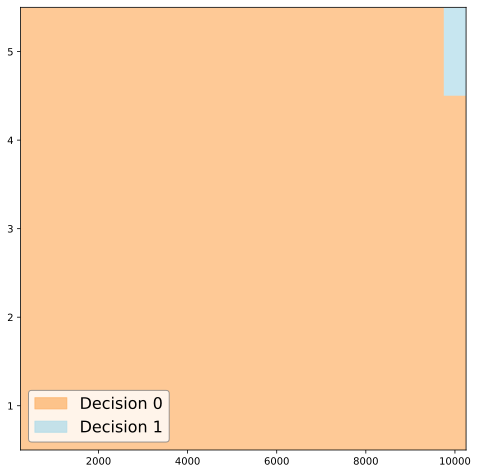

In [52]:
started_below = []
started_above = []
results = plot_decision_boundary_discrete_high_dims(
    'house_prices',
    ['area', 'bedrooms', 'bathrooms', 'floors'],
    filepath = '/home/kebl7418/projects/counterfactuals/results/house_prices/llama3_3_70B.json',
    fixed_vars = {"bathrooms":2, "floors": 2},
    verbose=0,
    points_to_mark_1=started_below,
    points_to_mark_2=started_above,
    offset=0.5,
    cf_density=True,
    save_path = REPO_ROOT / 'figures/decision_boundary_house_prices.png',
    legend_setting=True
)

# Continuous decision boundaries

In [53]:
def plot_decision_boundary_continuous(
    dataset_name: str,
    variables: list[str],
    *,
    filepath: str | Path,
    colours: tuple[str, str] = ("#FAD2C4", "#AEC9F4"),  # [RED, BLUE] # FED9CE
    save_path: str | Path | None = None,
    verbose: int = 0,
    points_to_mark: int | list[int] = 0,
    offset: float = 0.0,
    cf_density: bool = False,
    legend_labels: tuple[str, str] = ("Above $50,000", "Below $50,000"),
):
    """Plot a continuous decision boundary heatmap."""
    filepath = Path(filepath)
    model_name = filepath.stem

    results = postprocessing(filepath, force=True,
                             distance_metric="gower", save=True,
                             explicit_dataset="")
    results = {int(k): v for k, v in results.items()}

    with open(REPO_ROOT / 'src/models_datasets/datasets.json') as f:
        ds_info = json.load(f)[dataset_name]
    if ds_info.get('local', False):
        dataset = load_from_disk(REPO_ROOT / ds_info['filepath'])
    else:
        dataset = load_dataset(ds_info['filepath'], name=ds_info['name'], split=ds_info['split'])
    id_to_index = {id_: idx for idx, id_ in enumerate(dataset['id'])}
    option_to_code = {opt: i for i, opt in enumerate(ds_info['options'])}

    var0, var1, model_decision = [], [], []
    for v in tqdm(results.values(), desc='collect'):
        idx = id_to_index.get(v.get('dataset_id'))
        if idx is not None:
            v[variables[0]] = dataset[idx][variables[0]]
            v[variables[1]] = dataset[idx][variables[1]]
        else:
            v[variables[0]] = np.nan
            v[variables[1]] = np.nan
        val = v.get('original_answer', np.nan)
        try:
            val = float(val)
        except Exception:
            val = option_to_code.get(val, np.nan)
            val = val / (len(ds_info['options']) - 1 if len(ds_info['options']) > 1 else 1)
        var0.append(v[variables[0]])
        var1.append(v[variables[1]])
        model_decision.append(val)

    var0 = np.asarray(var0)
    var1 = np.asarray(var1)
    model_decision = np.asarray(model_decision)

    bins0 = np.arange(np.nanmin(var0), np.nanmax(var0) + 2, 1)
    bins1 = np.arange(np.nanmin(var1), np.nanmax(var1) + 2, 1)
    stat, _, _, _ = binned_statistic_2d(var0, var1, model_decision,
                                        statistic='mean', bins=[bins0, bins1])
    stat = np.ma.masked_where(np.isnan(stat), stat)

    alpha = 1
    colours = ["#FAD2C4", "#C9DBF7"]   # "#FFECE7", "#E0EAFB" "#fdae61", "#abd9e9"  # [RED, BLUE]
    colours_with_alpha = [mcolors.to_rgba(c, alpha=alpha) for c in colours]
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "OrangeDarkBlue",
        [
            (0.00, colours_with_alpha[0]),   # low extreme – same orange as before
            (0.50, "#3f007d"),   # mid – very dark violet/brown
            (1.00, colours_with_alpha[1]),   # high extreme – same light blue
        ],
        N=256                    # number of discrete steps
    )

    plt.figure(figsize=(10, 8))
    im = plt.imshow(stat.T, origin='lower', aspect='auto',
                    extent=[bins0[0], bins0[-1], bins1[0], bins1[-1]],
                    cmap=cmap, norm=mcolors.Normalize(0, 1), alpha=1)
    cbar = plt.colorbar(im)

    # Add legend with color boxes for the two extremes
    legend_handles = []
    # Add patches for the two extreme colors
    legend_handles.append(Patch(facecolor=colours[1], label=legend_labels[0], edgecolor='grey', linewidth=0.5))  # "Above $50,000" - blue
    legend_handles.append(Patch(facecolor=colours[0], label=legend_labels[1], edgecolor='grey', linewidth=0.5))  # "Below $50,000" - red

    if points_to_mark:
        samples = random.sample(list(results.keys()), points_to_mark) if isinstance(points_to_mark, int) else points_to_mark
        classes = ds_info['options']
        cf_coords = {c: {'x': [], 'y': []} for c in classes}
        for i in samples:
            try:
                vars_or = [x + '_OR' for x in variables]
                vars_cf = [x + '_CF' for x in variables]
                v = [results[i][var] for var in vars_or + vars_cf]
                target = results[i]['selected_complement']
                cf_coords[target]['x'].append(v[2] + offset)
                cf_coords[target]['y'].append(v[3] + offset)
                if not cf_density:
                    sce_x = results[i][variables[0] + '_CF_MIN']
                    sce_y = results[i][variables[1] + '_CF_MIN']
                    plt.scatter(v[0] + offset, v[1] + offset, color='red', s=60, marker='x')
                    plt.scatter(v[2] + offset, v[3] + offset, color='c', s=60, marker='x')
                    plt.scatter(sce_x + offset, sce_y + offset, color='k', s=60, marker='x')
                    plt.annotate('', xy=(v[2] + offset, v[3] + offset),
                                 xytext=(v[0] + offset, v[1] + offset),
                                 arrowprops=dict(arrowstyle='->', color='white', lw=1))
                    plt.plot([v[0] + offset, sce_x + offset],
                             [v[1] + offset, sce_y + offset], linestyle='--', color='k', lw=1)
            except Exception:
                continue
        if cf_density:
            for coords in cf_coords.values():
                plt.scatter(coords['x'], coords['y'], c='k', alpha=0.2, s=80)
        original_handle = Line2D([], [], marker='x', linestyle='None',
                                 markerfacecolor='red', markeredgecolor='red',
                                 markersize=8, label='Original inputs')
        counter_handle = Line2D([], [], marker='x', linestyle='None',
                                markerfacecolor='c', markeredgecolor='c',
                                markersize=8, label='Counterfactuals')
        sce_handle = Line2D([], [], marker='o', linestyle='None',
                            markerfacecolor='k', markeredgecolor='k',
                            markersize=8, label='SCEs')
        legend_handles.extend([original_handle, counter_handle, sce_handle])
    
    # Always show legend with color boxes
    if legend_handles:
        ax = plt.gca()
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.legend(handles=legend_handles, loc='lower left', frameon=True, fontsize=16)
        ax.get_legend().get_frame().set_edgecolor('grey')

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar.ax.tick_params(labelsize=0, length=4, width=1.2)

    ax = plt.gca()
    ax.tick_params(axis='x', labelbottom=False)  # or labeltop=False
    ax.tick_params(axis='y', labelleft=False)    # or labelright=False

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    return results

Extracted Dataset Name: 


collect:   0%|          | 0/1920 [00:00<?, ?it/s]

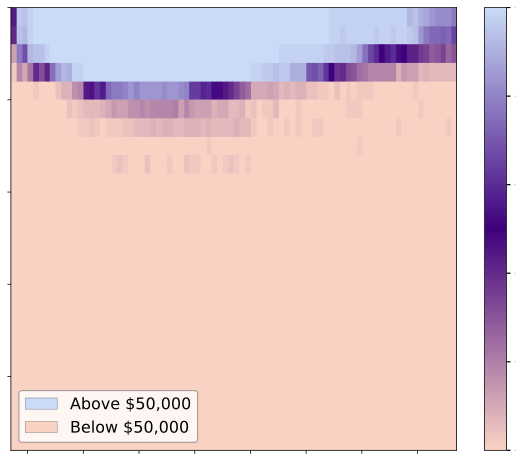

In [54]:
# where is this pulling data from...? Need the 50 different results for Llama 3.3 70B on the income dataset

results = plot_decision_boundary_continuous(
    'income',
    ['AGEP', 'SCHL'],
    filepath = REPO_ROOT / 'analysis/decision_boundary_consistency/average_50.json',
    verbose=0,
    points_to_mark=0, # started_below
    offset=0.5,
    cf_density=True,
    save_path = REPO_ROOT / 'figures/decision_boundary_50.png'
)